In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
time = np.arange(365 + 1)

x = np.random.randint(200,300,365)+200

In [0]:
split_time = 250
x_train = x[:split_time]
time_train = time[:split_time]
time_valid = time[split_time:]
x_valid = x[split_time:]

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
2/2 [==============================] - 5s 2s/step - loss: 496.6076 - mae: 500.3000 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 94ms/step - loss: 441.9332 - mae: 442.4332 - val_loss: 422.9511 - val_mae: 423.4511
Epoch 3/500
2/2 [==============================] - 0s 108ms/step - loss: 414.6713 - mae: 415.1713 - val_loss: 366.8595 - val_mae: 367.3595
Epoch 4/500
2/2 [==============================] - 0s 102ms/step - loss: 362.1278 - mae: 362.6278 - val_loss: 331.8523 - val_mae: 332.3523
Epoch 5/500
2/2 [==============================] - 0s 102ms/step - loss: 324.8923 - mae: 325.3923 - val_loss: 304.8515 - val_mae: 305.3515
Epoch 6/500
2/2 [==============================] - 0s 97ms/step - loss: 294.8919 - mae: 295.3919 - val_loss: 251.5010 - val_mae: 252.0010
Epoch 7/500
2/2 [==============================] - 0s 99ms/step - loss: 238.1383 - mae: 238.6383 - val_loss: 182.8873 - val_mae: 183.3873
Epoch 8/500
2/2 [============

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(model, tf.cast(x[:, np.newaxis], float), window_size)
rnn_forecast = rnn_forecast[split_time - window_size: -1, -1, 0]

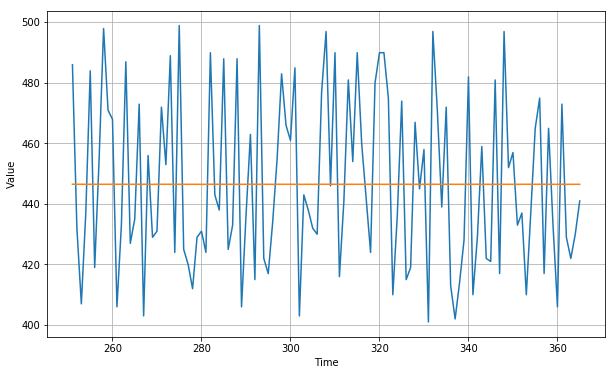

In [18]:
time_valid = time_valid[1:]
plt.figure(figsize= (10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

24.968948